In [24]:
from os import listdir
from os.path import isfile, join
import re
import csv
import gensim
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText
import logging
import os
import pandas as pd 
import sys
import sklearn.metrics
import sklearn
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import random
import math
import warnings
import utils
from utils_zj import *
import scipy.stats
from dataDictionariesLexicons import *
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.stats import linregress

random.seed(1)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore')

sys.path.insert(0, '../') 

from outletsBiasRatings import outletsBiasRatingsAllSides, outletsBiasRatingsMediaBiasFactCheck, outletsBiasRatingsFairReporters, outletsBiasRatingsAdFontesMedia, outletAbbreviationToFullName 
outletsBiasRatings = outletsBiasRatingsAllSides
outlets = list(outletsBiasRatings.keys())


In [25]:
# load models
models = {}

outlets = ['cbs','nyt', 'slate', 'reuters','thehill', 'csm', 'wt', 'nyp', 'dailymail']
for outlet in outlets:
    modelPath = os.path.normpath(f'../models/{outlet}/') 
    modelFilePath = os.path.join(modelPath, '2015-2019.model')
    try:
        model = KeyedVectors.load(modelFilePath) 
    except:
        continue
    models[outlet] = model 

In [26]:
models

{'cbs': <gensim.models.word2vec.Word2Vec at 0x107b0c390>,
 'nyt': <gensim.models.word2vec.Word2Vec at 0x6a2a93910>,
 'slate': <gensim.models.word2vec.Word2Vec at 0x324733910>,
 'reuters': <gensim.models.word2vec.Word2Vec at 0x6a28ab650>,
 'thehill': <gensim.models.word2vec.Word2Vec at 0x651507d90>,
 'csm': <gensim.models.word2vec.Word2Vec at 0x651507c90>,
 'wt': <gensim.models.word2vec.Word2Vec at 0x6a28bf790>,
 'nyp': <gensim.models.word2vec.Word2Vec at 0x651504410>,
 'dailymail': <gensim.models.word2vec.Word2Vec at 0x5d834f790>}

In [27]:
outletsBiasRatings = outletsBiasRatingsAllSides

leftwingOutlets = [k for k,v in outletsBiasRatings.items() if v < -1.5]
centerleftwingOutlets = [k for k,v in outletsBiasRatings.items() if v < 0 and v>= -1.5]
centerwingOutlets = [k for k,v in outletsBiasRatings.items() if v == 0]
centerrightwingOutlets = [k for k,v in outletsBiasRatings.items() if v > 0 and v<=1.5]
rightwingOutlets = [k for k,v in outletsBiasRatings.items() if v > 1.5]

## One Plot

In [28]:
RealDataTemp={
**harvardGeneralInquirer3623,**WEAT1,**vaderLexicon7062,**NRCEmotionLexicon5555,**opinionLexicon6786,**afinnLexicon2477,
**positiveNegativeAdjetives762,**positiveNegativeAdjetives197,**happySadAdjectives122,**niceMeanAdjetives228,
**intelligentDullAdjetives75,**inquirerViceVirtue1277,**inquirerHostileAffiliation1176,
**inquirerPowerConflictCooperation294,**inquirerAffectNegativePositive261,
**ideonomyPersonalityTraits526,**EMOTEvalence985,**EMOTELikeableness985,**EMOTELikeableness554,
}#Merging dictionaries
len(RealDataTemp)

15704

## Assemble lexicon size

In [29]:
sum(x>0 for x in list(RealDataTemp.values()))

6385

In [30]:
sum(x<0 for x in list(RealDataTemp.values()))

9318

In [31]:
#number of unique terms in all lexicons
len(RealDataTemp)

15704

In [32]:
RealDataTemp

{'abandon': -2.0,
 'abandonment': -1,
 'abate': -1,
 'abdicate': -1,
 'abhor': -1,
 'abide': 1,
 'abject': -1,
 'able': 1,
 'abnormal': -1,
 'abolish': -1,
 'abominable': -1,
 'abound': 1,
 'abrasive': -1,
 'abrupt': -1,
 'abscond': -1,
 'absence': -1,
 'absent': -1,
 'absent_minded': -1,
 'absentee': -1,
 'absolve': 2.0,
 'absorbent': 1,
 'absorption': 1,
 'absurd': -1,
 'absurdity': -1,
 'abundance': 1,
 'abundant': 1,
 'abuse': -1,
 'abyss': -1,
 'accede': 1,
 'accentuate': 1,
 'accept': 1,
 'acceptable': 1,
 'acceptance': 1,
 'accessible': 1,
 'accession': 1,
 'accident': -2.0,
 'acclaim': 1,
 'acclamation': 1,
 'accolade': 1,
 'accommodate': 1,
 'accommodation': 1,
 'accompaniment': 1,
 'accomplish': 2.0,
 'accomplishment': 1,
 'accord': 1,
 'accordance': 1,
 'accost': -1,
 'accountable': 1,
 'accrue': 1,
 'accuracy': 1,
 'accurate': 1,
 'accurateness': 1,
 'accursed': -1,
 'accusation': -1,
 'accuse': -1,
 'ache': -2.0,
 'achieve': 1,
 'achievement': 1,
 'acknowledgement': 1,
 'a

## OR Plot only one model

In [33]:
dataSetIndexes = ['1-1','1-2'] 

In [34]:
dataFrameAggregates=[]
for model in models.values():
    i=1
    dataFrameAggregate = pd.DataFrame(index=RealDataTemp.keys(), columns=['df1','df2'])
    dataFrameAggregate['RealValues'] = RealDataTemp.values() #Word Labels 1 or -1
    RealData = realDataFilter(model,RealDataTemp,0)#Filter out terms not in model vocabulary (Last parameter Flag prints out OOV words)
    for dataSetIndex in dataSetIndexes:
        print(dataDict[dataSetIndex]['name'])
        constructPole1 = dataDict[dataSetIndex]['constructPole1']
        constructPole2 = dataDict[dataSetIndex]['constructPole2']
        constructPole1 = list(map(str.lower,constructPole1))
        constructPole2 = list(map(str.lower,constructPole2))
        
        constructPole1,constructPole2 = constructsFilter(model,constructPole1,constructPole2)# Filter out terms not in model vocabulary

        RealData = realDataFilter(model,RealDataTemp,0)#Filter out terms not in model vocabulary (Last parameter Flag prints out OOV words)

        Axis = dimensionN(model, constructPole1,constructPole2)  
        AxisName='Axis'
        dataFrame = makeDF(model, RealData.keys(),Axis,AxisName)
        dataFrame['RealValues']=RealData.values()
        calculateCorrelations(dataFrame)
        print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
        
        dataFrameAggregate['df'+str(i)] = dataFrame['Axis'] 
        i+=1
    dataFrameAggregates.append(dataFrameAggregate)
    

personal ideology
Spearman: SignificanceResult(statistic=0.11760691499535189, pvalue=9.804401506317772e-39)
Pearson: PearsonRResult(statistic=0.12620914390926025, pvalue=2.1705047054110778e-44)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
party affiliation and political parties
Spearman: SignificanceResult(statistic=0.10765360967109978, pvalue=1.0684977125831747e-32)
Pearson: PearsonRResult(statistic=0.11023396685158113, pvalue=3.277032889337289e-34)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
personal ideology
Spearman: SignificanceResult(statistic=0.2854867319174944, pvalue=2.1033481121433363e-251)
Pearson: PearsonRResult(statistic=0.2904695196130618, pvalue=1.4050119580891902e-260)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
party affiliation and political parties
Spearman: SignificanceResult(statistic=0.17295281012104213, pvalue=4.269738142147664e-91)
Pearson: PearsonRResult(statistic=0.17861176488635816, pvalue=4.002

In [35]:
def outletNameToColor(outlet):
    if outletsBiasRatings[outlet] > 0:
        return 'red'
    elif outletsBiasRatings[outlet] == 0:
        return 'green'
    else:
        return 'blue'


/var/folders/m2/x_qq8xz538z7bwt8_hm2h4s40000gn/T/ipykernel_8696/135979686.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


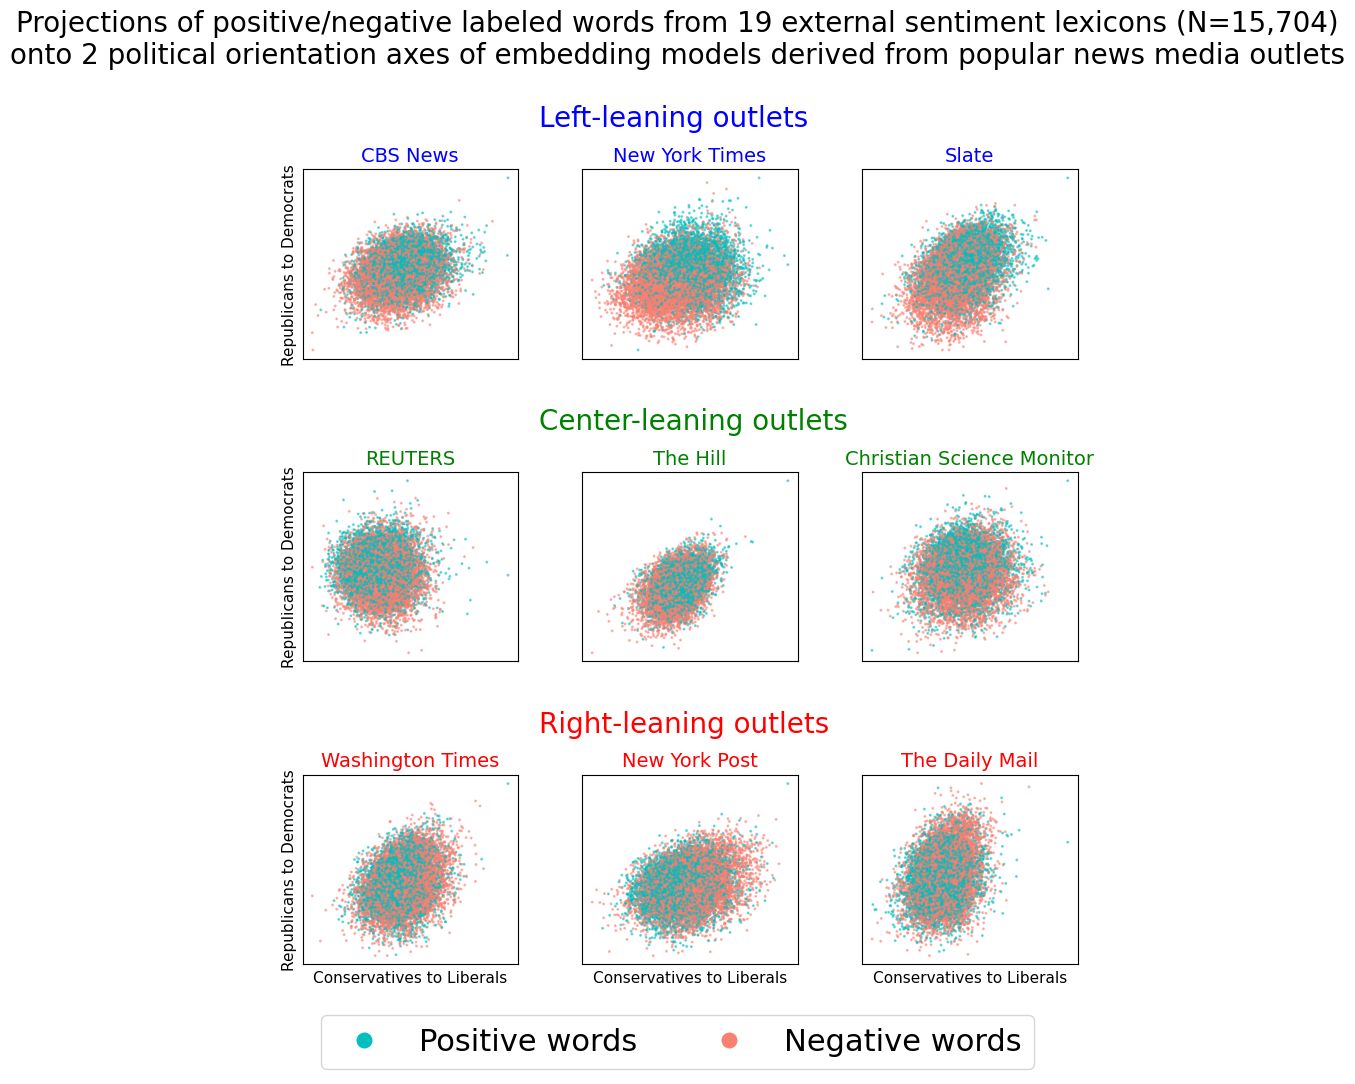

In [46]:
plt.rcParams['figure.figsize'] = [10,10]
alphaValue = 0.5#1#0.5#0.1

nrows=3
ncols=3

fig, ax = plt.subplots(nrows, ncols)
for pIndex, dataFrameAggregate in enumerate(dataFrameAggregates):
    plt.subplot(nrows, ncols, pIndex+1)
    #Colors is a list containing 'b' (blue) for dataFrameAggregate['RealValues']>0 and 'r' (red) for dataFrameAggregate['RealValues']<0
    colors = list(map(lambda x: 'c' if x == True else 'salmon', dataFrameAggregate['RealValues']>0))
    plt.scatter(dataFrameAggregate['df2'], dataFrameAggregate['df1'],s=5, alpha=alphaValue,marker='.',c=colors,)
    
    plt.title(outletAbbreviationToFullName[outlets[pIndex]], fontsize=14,color=outletNameToColor(outlets[pIndex]))
    if pIndex % 3 == 0:
        plt.ylabel("Republicans to Democrats",size=11)
    if pIndex >= 6:
        plt.xlabel("Conservatives to Liberals",size=11)        
        
    plt.xticks([])
    plt.yticks([])

plt.annotate("Left-leaning outlets",(-1.5,4.425),xycoords='axes fraction',fontsize=20,color="blue")
plt.annotate("Center-leaning outlets",(-1.5,2.825),xycoords='axes fraction',fontsize=20,color="green")
plt.annotate("Right-leaning outlets",(-1.5,1.225),xycoords='axes fraction',fontsize=20,color="red")

fig.suptitle('Projections of positive/negative labeled words from 19 external sentiment lexicons (N=15,704)\nonto 2 political orientation axes of embedding models derived from popular news media outlets',
             size=20, y=1.08)    #y=1.04

alphaValueLegend=1
legend_elements = [
        Line2D([0], [0], marker='.', color='w', markerfacecolor='c', label='Positive words', markersize=25),
        Line2D([0], [0], marker='.', color='w', markerfacecolor='salmon', label='Negative words', markersize=25),
                      ]
fig.legend(handles=legend_elements, loc="lower center",prop={'size': 22},ncol=2)
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.125   # the bottom of the subplots of the figure
top = 0.92      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.6  # the amount of height reserved for white space between subplots

fig.subplots_adjust(left, bottom, right, top, wspace, hspace)

fig.savefig(f'../figures/Figure 2_sentiment_projections.png',dpi=300,bbox_inches='tight',pad_inches=0)
fig.show()